In [ ]:
#parameters [0=Omega_matter,1=Omega_baryon, 2=h, 3=ns, 4=sigma8] 

**Extracting parameters from the 3D density distribution using a Deep Neural Network**

Paper: arXiv:2106.11061

In [ ]:
# load the relevant Python libraries
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import  Dense, Flatten, Conv3D, MaxPooling3D, Dropout,BatchNormalization
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir project

In [ ]:
! cp /content/drive/MyDrive/sims64v2.zip project/

In [ ]:
! unzip project/sims64v2.zip
! rm project/sims64v2.zip

In [ ]:
#read 3D density distribution (X) and the relevant input parameters (y)

def load_data():
    X = []
    y = []
    print('Read train images')
    for i in range(2000):
#        image_path = os.path.join('project/', 'df_m_64_z=0_r_'+ str(i) + '.npy')
        image_path = os.path.join('/content/files/df_m_64_z=0_r_'+ str(i) + '.npy')
        label_path = os.path.join('/content/files/params_r_'+ str(i) + '.dat')
        img = np.load(image_path)
        lbl = np.loadtxt(label_path)
        X.append(img)
        y.append(lbl)
    return X, y

In [ ]:
X,y = load_data()

Read train images


In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
X = X.reshape((-1, 64, 64, 64, 1))

In [ ]:
# split the data into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# scale the X and y data with a MinMaxScaler
min_max_scaler_y = MinMaxScaler()
y_train_minmax = min_max_scaler_y.fit_transform(y_train)
y_test_minmax = min_max_scaler_y.transform(y_test)

# Model for 5 paramters 

In [ ]:
# DNN model for predicting the 5 parameters
# create & compile model
model = tf.keras.models.Sequential()
model.add(Conv3D(12, kernel_size=(3, 3, 3), activation='relu', input_shape=X.shape[1:]))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(24, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, kernel_size=(9, 9, 9), activation='relu'))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
model.add(Conv3D(64, kernel_size=(2, 2, 2), activation='relu'))
model.add(Conv3D(64, kernel_size=(2, 2, 2), activation='relu'))


model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='relu'))

model.summary()
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
              metrics=['mse'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 62, 62, 62, 12)    336       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 31, 31, 31, 12)    0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 29, 29, 29, 24)    7800      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 14, 14, 14, 24)    0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 6, 6, 6, 64)       1119808   
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 4, 4, 4, 64)       110656    
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 3, 3, 3, 64)      

In [ ]:
# fit model on training data
history = model.fit(X_train,y_train , validation_split=0.1, epochs=20)

Epoch 1/20
45/45 [==============================] - 9s 194ms/step - loss: 0.3575 - mse: 0.3575 - val_loss: 0.1252 - val_mse: 0.1252
Epoch 2/20
45/45 [==============================] - 9s 193ms/step - loss: 0.1209 - mse: 0.1209 - val_loss: 0.1157 - val_mse: 0.1157
Epoch 3/20
45/45 [==============================] - 9s 195ms/step - loss: 0.1144 - mse: 0.1144 - val_loss: 0.1125 - val_mse: 0.1125
Epoch 4/20
45/45 [==============================] - 9s 197ms/step - loss: 0.1115 - mse: 0.1115 - val_loss: 0.1106 - val_mse: 0.1106
Epoch 5/20
45/45 [==============================] - 9s 200ms/step - loss: 0.1112 - mse: 0.1112 - val_loss: 0.1100 - val_mse: 0.1100
Epoch 6/20
45/45 [==============================] - 9s 193ms/step - loss: 0.1085 - mse: 0.1085 - val_loss: 0.1083 - val_mse: 0.1083
Epoch 7/20
45/45 [==============================] - 9s 198ms/step - loss: 0.1081 - mse: 0.1081 - val_loss: 0.1080 - val_mse: 0.1080
Epoch 8/20
45/45 [==============================] - 9s 192ms/step - loss: 0.

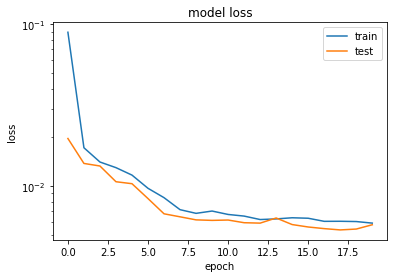

In [ ]:
# plot the learning curve
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

13/13 [==============================] - 1s 78ms/step - loss: 0.0059 - mse: 0.0059


Text(0, 0.5, 'True value')

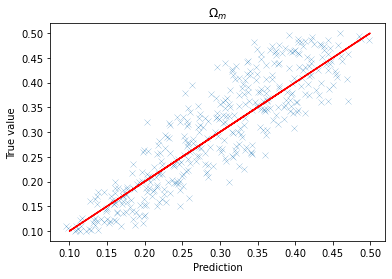

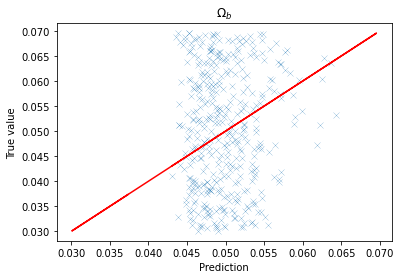

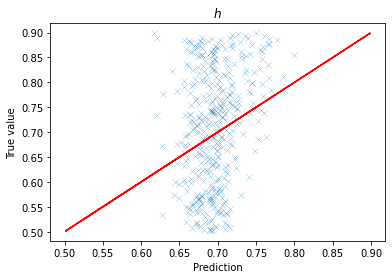

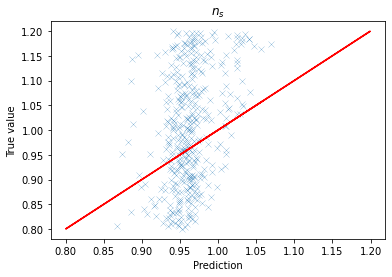

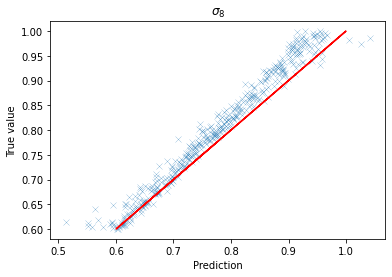

In [ ]:
# make predictions on the test set and plot results vs ground truths
model.evaluate(X_test,y_test)

pred=model.predict(X_test)

plt.figure()
plt.scatter(pred[:,0],y_test[:,0],marker='x',linewidth=0.2)
plt.plot(y_test[:,0],y_test[:,0],'r')
plt.title('$\Omega_m$')
plt.xlabel('Prediction')
plt.ylabel('True value')

plt.figure()
plt.scatter(pred[:,1],y_test[:,1],marker='x',linewidth=0.2)
plt.plot(y_test[:,1],y_test[:,1],'r')
plt.title('$\Omega_b$')
plt.xlabel('Prediction')
plt.ylabel('True value')

plt.figure()
plt.scatter(pred[:,2],y_test[:,2],marker='x',linewidth=0.2)
plt.plot(y_test[:,2],y_test[:,2],'r')
plt.title('$h$')
plt.xlabel('Prediction')
plt.ylabel('True value')
#
plt.figure()
plt.scatter(pred[:,3],y_test[:,3],marker='x',linewidth=0.2)
plt.plot(y_test[:,3],y_test[:,3],'r')
plt.title('$n_s$')
plt.xlabel('Prediction')
plt.ylabel('True value')
#
plt.figure()
plt.scatter(pred[:,4],y_test[:,4],marker='x',linewidth=0.2)
plt.plot(y_test[:,4],y_test[:,4],'r')
plt.title('$\sigma_8$')
plt.xlabel('Prediction')
plt.ylabel('True value')

# DNN models that predict just one parameter

# Omega_m

In [ ]:

tf.keras.backend.clear_session()
model2 = tf.keras.models.Sequential()
model2.add(Conv3D(2, kernel_size=(3, 3, 3), activation='relu', input_shape=X.shape[1:]))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(Conv3D(64, kernel_size=(2, 2, 2), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(64, kernel_size=(9, 9, 9), activation='relu'))
model2.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
model2.add(Conv3D(128, kernel_size=(2, 2, 2), activation='relu'))


model2.add(Flatten())
model2.add(Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.05)))
model2.add(Dense(1024, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.05)))
model2.add(Dense(1, activation='linear'))

model2.summary()

model2.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['mse'])

history2 = model2.fit(X_train,y_train[:,[0]], validation_split=0.1, epochs=75)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 62, 62, 62, 2)     56        
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 62, 2)     8         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 31, 31, 31, 2)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 30, 30, 30, 64)    1088      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 30, 64)    256       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 15, 15, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 7, 7, 64)       2

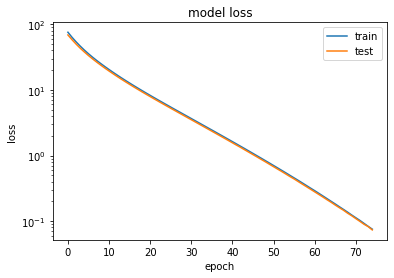

13/13 [==============================] - 1s 52ms/step - loss: 0.0735 - mse: 0.0029


Text(0, 0.5, 'True value')

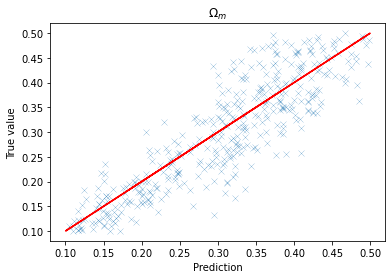

In [ ]:
  #Learning curve
plt.figure()
plt.semilogy(history2.history['loss'])
plt.semilogy(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

model2.evaluate(X_test,y_test[:,[0]])

pred2=model2.predict(X_test)
#
plt.figure()
plt.scatter(pred2[:,0],y_test[:,0],marker='x',linewidth=0.2)
plt.plot(y_test[:,0],y_test[:,0],'r')
plt.title('$\Omega_m$')
plt.xlabel('Prediction')
plt.ylabel('True value')


# 2nd model to predict 5 parameters

In [ ]:
tf.keras.backend.clear_session()
model2 = tf.keras.models.Sequential()
model2.add(Conv3D(2, kernel_size=(3, 3, 3), activation='relu', input_shape=X.shape[1:]))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(Conv3D(64, kernel_size=(2, 2, 2), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(64, kernel_size=(9, 9, 9), activation='relu'))
model2.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
#model2.add(Conv3D(128, kernel_size=(2, 2, 2), activation='relu'))
model2.add(Conv3D(128, kernel_size=(2, 2, 2), activation='relu'))


model2.add(Flatten())
model2.add(Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.05)))
model2.add(Dense(1024, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.05)))
model2.add(Dense(5, activation='linear'))

model2.summary()

model2.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['mse'])

history2 = model2.fit(X_train,y_train, validation_split=0.1, epochs=75)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 62, 62, 62, 2)     56        
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 62, 2)     8         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 31, 31, 31, 2)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 30, 30, 30, 64)    1088      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 30, 64)    256       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 15, 15, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 7, 7, 64)       2

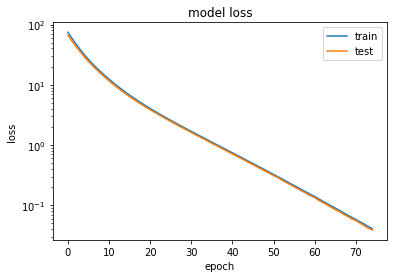

13/13 [==============================] - 1s 53ms/step - loss: 0.0393 - mse: 0.0065


In [ ]:
# plot the learning curve
plt.figure()
plt.semilogy(history2.history['loss'])
plt.semilogy(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

model2.evaluate(X_test,y_test)

pred2=model2.predict(X_test)

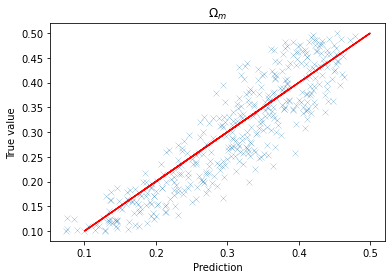

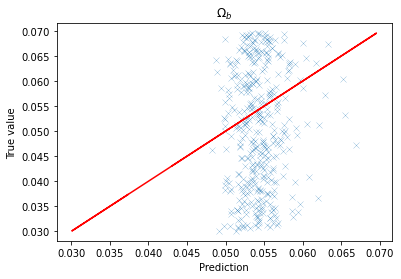

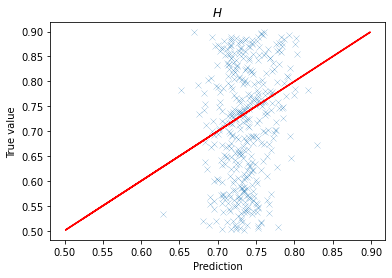

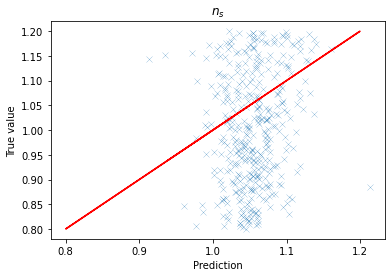

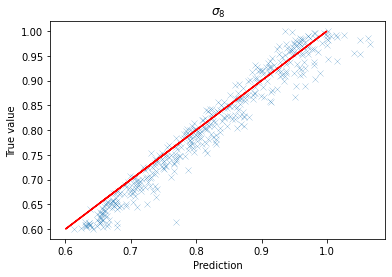

In [ ]:
# plot the predictions
for i in range(5):
  plt.figure()
  plt.scatter(pred2[:,i],y_test[:,i],marker='x',linewidth=0.2)
  plt.plot(y_test[:,i],y_test[:,i],'r')
  if (i==0):
    plt.title('$\Omega_m$')
  if (i==1):
    plt.title('$\Omega_b$')
  if (i==2):
    plt.title('$H$')
  if (i==3):
    plt.title('$n_s$')
  if (i==4):
    plt.title('$\sigma_8$')  
  plt.xlabel('Prediction')
  plt.ylabel('True value')


# Model to predict Omega_m and sigma_8

In [ ]:
tf.keras.backend.clear_session()
#model Shirley Ho 1 param
model2 = tf.keras.models.Sequential()
model2.add(Conv3D(2, kernel_size=(3, 3, 3), activation='relu', input_shape=X.shape[1:]))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(Conv3D(64, kernel_size=(2, 2, 2), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(64, kernel_size=(9, 9, 9), activation='relu'))
model2.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
#model2.add(Conv3D(128, kernel_size=(2, 2, 2), activation='relu'))
model2.add(Conv3D(128, kernel_size=(2, 2, 2), activation='relu'))


model2.add(Flatten())
model2.add(Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.05)))
model2.add(Dense(1024, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.05)))
model2.add(Dense(2, activation='linear'))

model2.summary()

model2.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['mse'])


history2 = model2.fit(X_train,y_train_minmax[:,[0,4]], validation_split=0.1, epochs=50)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 62, 62, 62, 2)     56        
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 62, 2)     8         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 31, 31, 31, 2)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 30, 30, 30, 64)    1088      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 30, 64)    256       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 15, 15, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 7, 7, 64)       2

In [ ]:
# plot the learning curve
plt.figure()
plt.semilogy(history2.history['mse'])
plt.semilogy(history2.history['val_mse'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

model2.evaluate(X_test,y_test_minmax[:,[0,4]])

pred2=model2.predict(X_test)

Text(0.5, 1.0, '$\\sigma_8$')

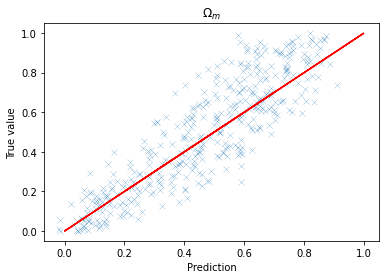

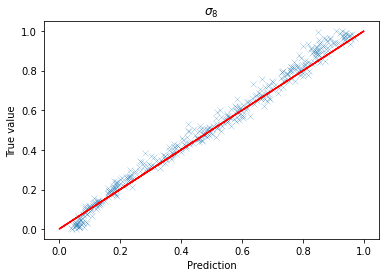

In [ ]:
# plot the predictions
plt.figure()
plt.scatter(pred2[:,0],y_test_minmax[:,0],marker='x',linewidth=0.2)
plt.plot(y_test_minmax[:,0],y_test_minmax[:,0],'r')
plt.title('$\Omega_m$')
plt.xlabel('Prediction')
plt.ylabel('True value')

plt.figure()
plt.scatter(pred2[:,1],y_test_minmax[:,4],marker='x',linewidth=0.2)
plt.plot(y_test_minmax[:,4],y_test_minmax[:,4],'r')
plt.xlabel('Prediction')
plt.ylabel('True value')
plt.title('$\sigma_8$')  


# Model to predict Omega_m

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 62, 62, 62, 2)     56        
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 62, 2)     8         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 31, 31, 31, 2)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 30, 30, 30, 64)    1088      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 30, 64)    256       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 15, 15, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 7, 7, 64)       2

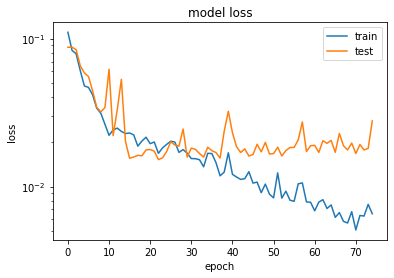

13/13 [==============================] - 1s 52ms/step - loss: 0.0320 - mse: 0.0320


Text(0, 0.5, 'True value')

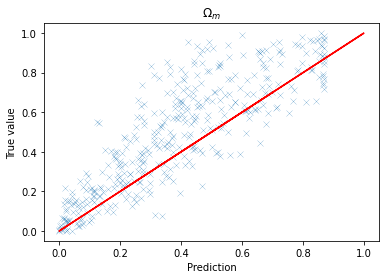

In [ ]:
tf.keras.backend.clear_session()
model2 = tf.keras.models.Sequential()
model2.add(Conv3D(2, kernel_size=(3, 3, 3), activation='relu', input_shape=X.shape[1:]))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(Conv3D(64, kernel_size=(2, 2, 2), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(64, kernel_size=(9, 9, 9), activation='relu'))
model2.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))

model2.add(Conv3D(128, kernel_size=(2, 2, 2), activation='relu'))


model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.7))
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.7))
model2.add(Dense(1, activation='sigmoid'))

model2.summary()

model2.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              metrics=['mse'])

history2 = model2.fit(X_train,y_train_minmax[:,[0]], validation_split=0.1, epochs=75)

# plot the learning curve
plt.figure()
plt.semilogy(history2.history['mse'])
plt.semilogy(history2.history['val_mse'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

model2.evaluate(X_test,y_test_minmax[:,[0]])

pred2 = model2.predict(X_test)
#
plt.figure()
plt.scatter(pred2[:,0],y_test_minmax[:,0],marker='x',linewidth=0.2)
plt.plot(y_test_minmax[:,0],y_test_minmax[:,0],'r')
plt.title('$\Omega_m$')
plt.xlabel('Prediction')
plt.ylabel('True value')

Text(0, 0.5, 'True value')

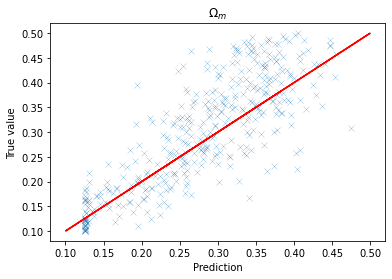

In [ ]:
# scale results to original ranges
pred3=min_max_scaler_y.inverse_transform(np.array([pred2.reshape(400),]*5).T)[:, [0]]
plt.figure()
plt.scatter(pred3[:,0],y_test[:,0],marker='x',linewidth=0.2)
plt.plot(y_test[:,0],y_test[:,0],'r')
plt.title('$\Omega_m$')
plt.xlabel('Prediction')
plt.ylabel('True value')

# Model to predict Omega_b

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 62, 62, 62, 2)     56        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 31, 31, 31, 2)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 30, 30, 30, 128)   2176      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 15, 15, 128)   0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 7, 7, 64)       5972032   
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 5, 5, 5, 64)       110656    
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 4, 4, 4, 128)      6

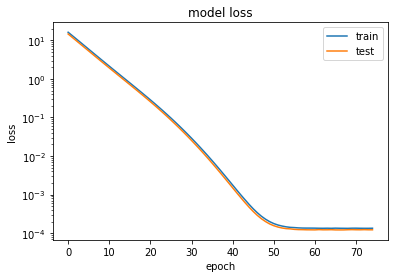

13/13 [==============================] - 1s 79ms/step - loss: 1.4120e-04 - mse: 1.4119e-04


Text(0, 0.5, 'True value')

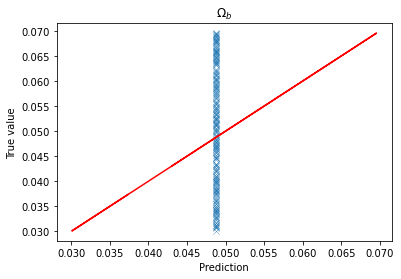

In [ ]:
tf.keras.backend.clear_session()
model2 = tf.keras.models.Sequential()
model2.add(Conv3D(2, kernel_size=(3, 3, 3), activation='relu', input_shape=X.shape[1:]))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(Conv3D(128, kernel_size=(2, 2, 2), activation='relu'))

model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(64, kernel_size=(9, 9, 9), activation='relu'))
model2.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
model2.add(Conv3D(128, kernel_size=(2, 2, 2), activation='relu'))


model2.add(Flatten())
model2.add(Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model2.add(Dense(2048, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model2.add(Dense(1, activation='linear'))

model2.summary()

model2.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              metrics=['mse'])

history2 = model2.fit(X_train,y_train[:,[1]], validation_split=0.1, epochs=75)

# plot the learning curve
plt.figure()
plt.semilogy(history2.history['loss'])
plt.semilogy(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

model2.evaluate(X_test,y_test[:,[1]])

pred2=model2.predict(X_test)
#
plt.figure()
plt.scatter(pred2[:,0],y_test[:,1],marker='x',linewidth=0.2)
plt.plot(y_test[:,1],y_test[:,1],'r')
plt.title('$\Omega_b$')
plt.xlabel('Prediction')
plt.ylabel('True value')

# Model to predict h

In [ ]:
tf.keras.backend.clear_session()
model2 = tf.keras.models.Sequential()
model2.add(Conv3D(2, kernel_size=(3, 3, 3), activation='relu', input_shape=X.shape[1:]))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(Conv3D(128, kernel_size=(2, 2, 2), activation='relu'))

model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(64, kernel_size=(9, 9, 9), activation='relu'))
model2.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
model2.add(Conv3D(128, kernel_size=(2, 2, 2), activation='relu'))


model2.add(Flatten())
model2.add(Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model2.add(Dense(2048, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model2.add(Dense(1, activation='linear'))

model2.summary()

model2.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              metrics=['mse'])

history2 = model2.fit(X_train,y_train[:,[2]], validation_split=0.1, epochs=75)

# plot the learning curve
plt.figure()
plt.semilogy(history2.history['loss'])
plt.semilogy(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

model2.evaluate(X_test,y_test[:,[2]])
pred2 = model2.predict(X_test)
#
plt.figure()
plt.scatter(pred2[:,0],y_test[:,2],marker='x',linewidth=0.2)
plt.plot(y_test[:,2],y_test[:,2],'r')
plt.title('$\Omega_b$')
plt.xlabel('Prediction')
plt.ylabel('True value')

# Model to predict sigma_8

In [ ]:
#model Shirley Ho 1 param
model2 = tf.keras.models.Sequential()
model2.add(Conv3D(2, kernel_size=(3, 3, 3), activation='relu', input_shape=X.shape[1:]))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(Conv3D(12, kernel_size=(3, 3, 3), activation='relu'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(64, kernel_size=(9, 9, 9), activation='relu'))
model2.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
model2.add(Conv3D(128, kernel_size=(2, 2, 2), activation='relu'))
model2.add(Conv3D(128, kernel_size=(2, 2, 2), activation='relu'))


model2.add(Flatten())
model2.add(Dense(1024, activation='relu'))
#model.add(BatchNormalization())
model2.add(Dense(256, activation='relu'))
#model.add(BatchNormalization())
model2.add(Dense(1, activation='linear'))

In [ ]:
model2.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_104 (Conv3D)          (None, 62, 62, 62, 2)     56        
_________________________________________________________________
max_pooling3d_36 (MaxPooling (None, 31, 31, 31, 2)     0         
_________________________________________________________________
conv3d_105 (Conv3D)          (None, 29, 29, 29, 12)    660       
_________________________________________________________________
max_pooling3d_37 (MaxPooling (None, 14, 14, 14, 12)    0         
_________________________________________________________________
conv3d_106 (Conv3D)          (None, 6, 6, 6, 64)       559936    
_________________________________________________________________
conv3d_107 (Conv3D)          (None, 4, 4, 4, 64)       110656    
_________________________________________________________________
conv3d_108 (Conv3D)          (None, 3, 3, 3, 128)    

In [ ]:
model2.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['mse'])

In [ ]:
history2 = model2.fit(X_train,y_train[:,[4]], batch_size=32, validation_split=0.1, epochs=75)

Epoch 1/75
45/45 [==============================] - 4s 85ms/step - loss: 3.5742 - mse: 3.5742 - val_loss: 0.0362 - val_mse: 0.0362
Epoch 2/75
45/45 [==============================] - 4s 80ms/step - loss: 0.0216 - mse: 0.0216 - val_loss: 0.0148 - val_mse: 0.0148
Epoch 3/75
45/45 [==============================] - 4s 81ms/step - loss: 0.0165 - mse: 0.0165 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 4/75
45/45 [==============================] - 4s 81ms/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0137 - val_mse: 0.0137
Epoch 5/75
45/45 [==============================] - 4s 82ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 6/75
45/45 [==============================] - 4s 82ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 7/75
45/45 [==============================] - 4s 80ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 8/75
45/45 [==============================] - 4s 81ms/step - loss: 0.0017 - m

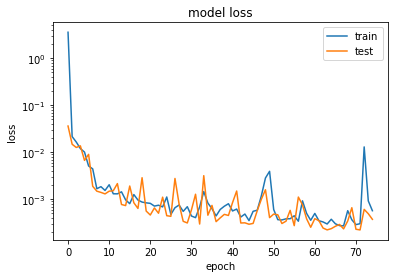

In [ ]:
# plot the learning curve
plt.semilogy(history2.history['loss'])
plt.semilogy(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

13/13 [==============================] - 0s 36ms/step - loss: 3.4458e-04 - mse: 3.4458e-04


Text(0, 0.5, 'True value')

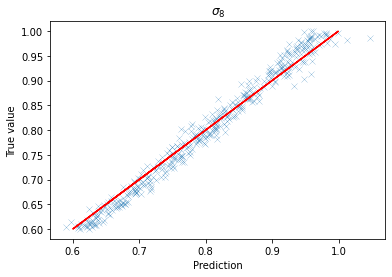

In [ ]:
model2.evaluate(X_test,y_test[:,[4]])

pred2=model2.predict(X_test)
#
plt.figure()
plt.scatter(pred2[:,0],y_test[:,4],marker='x',linewidth=0.2)
plt.plot(y_test[:,4],y_test[:,4],'r')
plt.title('$\sigma_8$')
plt.xlabel('Prediction')
plt.ylabel('True value')


#plt.figure()
#plt.scatter(pred2[:,1],y_test[:,4],marker='x',linewidth=0.2)
#plt.plot(y_test[:,4],y_test[:,4],'r')
#plt.title('$\sigma_8$')
#plt.xlabel('Prediction')
#plt.ylabel('True value')